# Team Members
| Name | Code |
| --- | --- |
| Ali Mohsen Yehia | 2000289 |
| Zeyad Waleed Amin | 2000447 |
| Ahmed Mohamed Atwa | 2001391 |

# Table of Contents

- [Prepare the Data](#prepare-the-data)
  - [Libraries Imports](#libraries-imports)
  - [Load the Data](#load-the-data)
  - [Visualize the Data](#visualize-the-data)
  - [Split the Data](#split-the-data)
  - [Useful Functions](#useful-functions)
- [K Nearest Neighbors](#k-nearest-neighbors)
  - [Train and Validate the Model](#train-and-validate-the-model)
  - [Test the Model](#test-the-model)
- [Logistic Regression](#logistic-regression)
  - [Train the Model](#train-the-model)
  - [Validate the Model](#validate-the-model)
    - [First Trail](#first-trail)
    - [Second Trail](#second-trail)
  - [Test the Model](#test-the-model-1)
- [Naive Bayes](#naive-bayes)
  - [Train the Model](#train-the-model-1)
  - [Validate the Model](#validate-the-model-1)
    - [First Trail](#first-trail-1)
    - [Second Trail](#second-trail-1)
  - [Test the Model](#test-the-model-2)
- [Results Summary](#results-summary)
  - [ROC Curves](#roc-curves)
  - [Other Metrics](#other-metrics)

# Prepare the Data

## Libraries Imports

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## Load the Data

In [69]:
names =[
    'index',
    'location', 'country',                                                  # the country and location of the person
    'gender', 'age',                                                        # gender and age of the person
    'vis_wuhan', 'from_wuhan',                                              # whether the person visited wuhan or from wuhan
    'symptom1', 'symptom2', 'symptom3', 'symptom4', 'symptom5', 'symptom6', # symptoms appeared on the person
    'diff_sym_hos',                                                         # time before symptoms appear
    'result'                                                                # death or recovered
]
df = pd.read_csv("data.csv", names = names)
df.drop(index = 0, axis = 1, inplace = True)

In [70]:
df.head(5)

,index,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
1,0.0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
2,1.0,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
3,2.0,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
4,3.0,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
5,4.0,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


## Visualize the Data
We notice that 0 class is much more common than 1 class (unbalanced data)

<Axes: xlabel='result'>

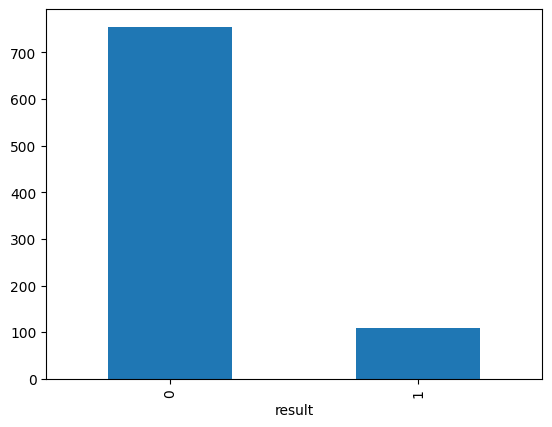

In [71]:
df["result"].value_counts().plot(kind="bar")

## Split the Data
Split the data into train - validate - test (60 - 20 - 20)

In [72]:
X_data = df[['location', 'country', 'gender', 'age', 'vis_wuhan', 'from_wuhan', 'symptom1', 'symptom2', 'symptom3', 'symptom4', 'symptom5', 'symptom6', 'diff_sym_hos']].astype('float')
y_data = df['result'].astype('int')

# Split into train/validate and test
X_train_and_validate, X_test, y_train_and_validate, y_test = train_test_split(
    X_data, y_data, random_state=1, train_size=0.8, shuffle=True, stratify=y_data
)

# Split train and validate
X_train, X_validate, y_train, y_validate = train_test_split(
    X_train_and_validate, y_train_and_validate, random_state=5, train_size=0.75, shuffle=True, stratify=y_train_and_validate
)


## Useful Functions

In [73]:
def get_metrics(y, y_pred, y_prob):
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_prob)

    metrics_table = pd.DataFrame({
        "metric": ["Accuracy", "Precision", "Recall", "F1", "ROC AUC"],
        "values": [accuracy, precision, recall, f1, roc_auc]
    })
    metrics_table["values"] *= 100

    return metrics_table

In [74]:
curves = []
def draw_roc(y, y_prob):
    fpr, tpr, thresholds = roc_curve(y, y_prob)
    curves.append([fpr, tpr, roc_auc_score(y, y_prob)])
    plt.plot(fpr, tpr, color='blue', label='ROC Curve')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='random classifier')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

# K Nearest Neighbors

## Train and Validate the Model

In [75]:
from sklearn.neighbors import KNeighborsClassifier

best_knn_score = 0
best_knn_params = {}
best_knn = None

# For loop with different hyperparameters
for n_neighbors in range(1, 21):
    for weights in ['uniform', 'distance']:
        for metric in ['euclidean', 'manhattan']:

            # Set the model with hyperparameters
            knn_clf = KNeighborsClassifier(
                n_neighbors = n_neighbors, weights = weights, metric = metric
            )

            # Train the model on training data
            knn_clf.fit(X_train, y_train)

            # Calculate the score based on validation data
            y_validate_pred = knn_clf.predict(X_validate)
            score = f1_score(y_validate, y_validate_pred)

            # Find model with best score
            if score > best_knn_score:
                best_knn_score = score
                best_knn_params = {
                    'n_neighbors': n_neighbors,
                    'weights': weights,
                    'metric': metric
                }
                best_knn = knn_clf

knn_clf = best_knn
best_knn_params

{'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}

## Test the Model

In [76]:
# Calculate the predicted result
y_test_pred = knn_clf.predict(X_test)
y_test_prob = knn_clf.predict_proba(X_test)[:, 1]

In [77]:
# Compute test metrics
knn_metrics = get_metrics(y_test, y_test_pred, y_test_prob)
knn_metrics

,metric,values
0,Accuracy,93.063584
1,Precision,81.250000
2,Recall,59.090909
3,F1,68.421053
4,ROC AUC,95.334136


<Axes: >

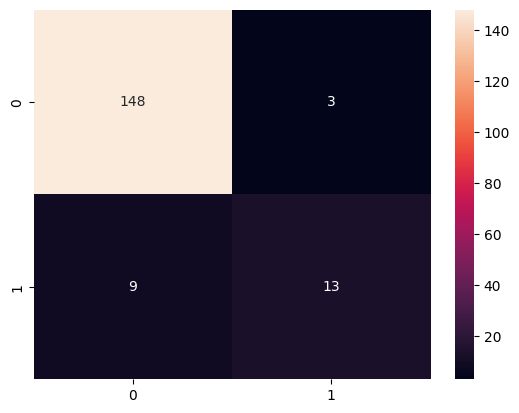

In [78]:
# Compute the confusion matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix_test, annot=True, fmt='.0f')

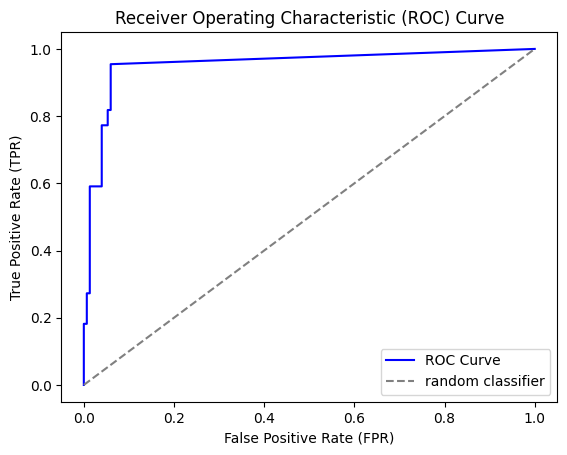

In [79]:
draw_roc(y_test, y_test_prob)

# Logistic Regression

## Train the Model

In [80]:
from sklearn import linear_model, preprocessing

# Scale the Data for better fitting
min_max_scaler = preprocessing.MinMaxScaler()

X_train_scaled = min_max_scaler.fit_transform(X_train)
X_validate_scaled = min_max_scaler.fit_transform(X_validate)
X_test_scaled = min_max_scaler.fit_transform(X_test)

In [81]:
# Fit the model
logistic_clf = linear_model.LogisticRegression()
logistic_clf.fit(X_train_scaled, y_train)

LogisticRegression()

## Validate the Model

### First Trail

In [82]:
# Calculate the predicted result
y_validate_pred = logistic_clf.predict(X_validate_scaled)
y_validate_prob = logistic_clf.predict_proba(X_validate_scaled)[:, 1]

In [83]:
# Compute test metrics
get_metrics(y_validate, y_validate_pred, y_validate_prob)

,metric,values
0,Accuracy,87.861272
1,Precision,100.000000
2,Recall,4.545455
3,F1,8.695652
4,ROC AUC,94.581577


We notice that the recall is very bad, this is because of the unbalanced data

So we need to set a higher weight for the "1" class

### Second Trail

In [84]:
# change class weight and fit the model again
logistic_clf.class_weight = {0: 1, 1: 5}
logistic_clf.fit(X_train_scaled, y_train)

# Calculate the predicted result
y_validate_pred = logistic_clf.predict(X_validate_scaled)
y_validate_prob = logistic_clf.predict_proba(X_validate_scaled)[:, 1]

In [85]:
# Compute test metrics
get_metrics(y_validate, y_validate_pred, y_validate_prob)

,metric,values
0,Accuracy,91.907514
1,Precision,90.000000
2,Recall,40.909091
3,F1,56.250000
4,ROC AUC,95.484648


The recall is better now

## Test the Model

In [86]:
# Calculate the predicted result
y_test_pred = logistic_clf.predict(X_test_scaled)
y_test_prob = logistic_clf.predict_proba(X_test_scaled)[:, 1]

In [87]:
# Compute test metrics
logistic_metrics = get_metrics(y_test, y_test_pred, y_test_prob)
logistic_metrics

,metric,values
0,Accuracy,93.641618
1,Precision,67.741935
2,Recall,95.454545
3,F1,79.245283
4,ROC AUC,98.314269


<Axes: >

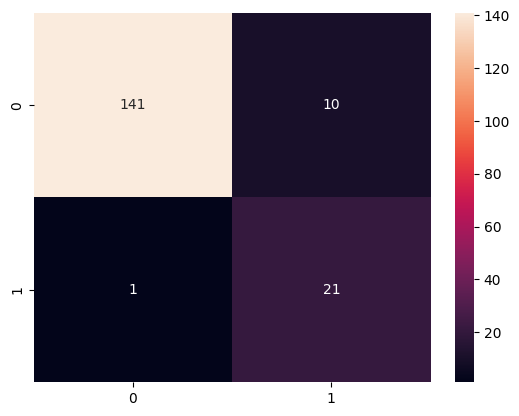

In [88]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='.0f')

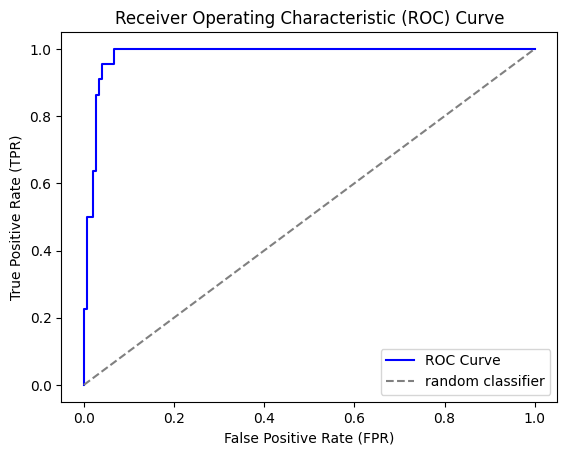

In [89]:
draw_roc(y_test, y_test_prob)

# Naive Bayes

## Train the Model

In [90]:
from sklearn.naive_bayes import GaussianNB

# Fit the model
bayes_clf = GaussianNB()
bayes_clf.fit(X_train, y_train)

GaussianNB()

## Validate the Model

### First Trail

In [91]:
# Calculate the predicted result
y_validate_pred = bayes_clf.predict(X_validate)
y_validate_prob = bayes_clf.predict_proba(X_validate)[:, 1]

In [92]:
# Compute test metrics
get_metrics(y_validate, y_validate_pred, y_validate_prob)

,metric,values
0,Accuracy,27.745665
1,Precision,14.482759
2,Recall,95.454545
3,F1,25.149701
4,ROC AUC,87.477423


We notice that the precision is very bad which means that the model is affected by small variance of data

We add variance smoothing to the model to make it more stable to small variance

### Second Trail

In [93]:
# change variance smoothing and fit the model again
bayes_clf.var_smoothing = 1e-5
bayes_clf.fit(X_train, y_train)

# Calculate the predicted result
y_validate_pred = bayes_clf.predict(X_validate)
y_validate_prob = bayes_clf.predict_proba(X_validate)[:, 1]

In [94]:
# Compute test metrics
get_metrics(y_validate, y_validate_pred, y_validate_prob)

,metric,values
0,Accuracy,89.017341
1,Precision,55.555556
2,Recall,68.181818
3,F1,61.224490
4,ROC AUC,87.748344


## Test the Model

In [95]:
# Calculate the predicted result
y_test_pred = bayes_clf.predict(X_test)
y_test_prob = bayes_clf.predict_proba(X_test)[:, 1]

In [96]:
# Compute test metrics
bayes_metrics = get_metrics(y_test, y_test_pred, y_test_prob)
bayes_metrics

,metric,values
0,Accuracy,90.751445
1,Precision,58.823529
2,Recall,90.909091
3,F1,71.428571
4,ROC AUC,95.484648


<Axes: >

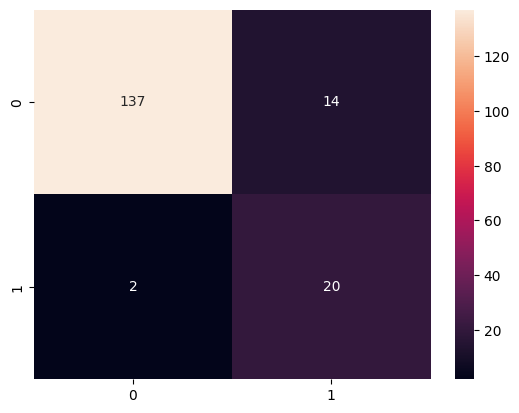

In [97]:
# Compute the confusion matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix_test, annot=True, fmt='.0f')

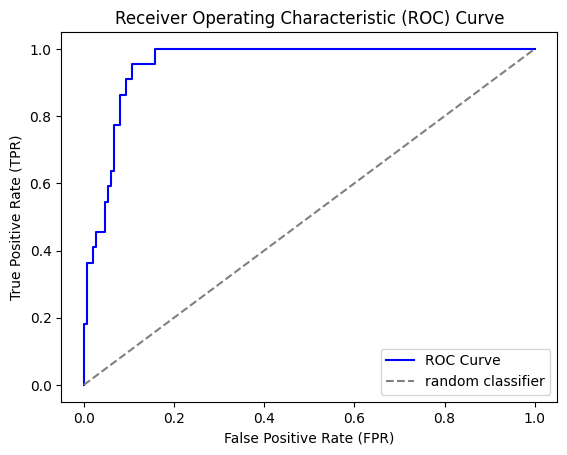

In [98]:
draw_roc(y_test, y_test_prob)

# Decision Tree

## Train the Model

In [99]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree classifier
decision_tree_clf = DecisionTreeClassifier(random_state=0)

# Train the model on training data
decision_tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

## Validate the Model

In [100]:
# Validate the model on validation data
y_validate_pred = decision_tree_clf.predict(X_validate)
y_validate_prob = decision_tree_clf.predict_proba(X_validate)[:, 1]

In [101]:
# Compute validation metrics
decision_tree_metrics = get_metrics(y_validate, y_validate_pred, y_validate_prob)
decision_tree_metrics

,metric,values
0,Accuracy,96.531792
1,Precision,90.000000
2,Recall,81.818182
3,F1,85.714286
4,ROC AUC,90.246839


## Test the Model

In [102]:
# Calculate the predicted result on test data
y_test_pred = decision_tree_clf.predict(X_test)
y_test_prob = decision_tree_clf.predict_proba(X_test)[:, 1]

# Compute test metrics
decision_tree_metrics = get_metrics(y_test, y_test_pred, y_test_prob)
decision_tree_metrics

,metric,values
0,Accuracy,97.109827
1,Precision,90.476190
2,Recall,86.363636
3,F1,88.372093
4,ROC AUC,92.519567


In [103]:
# Compute test metrics
bayes_metrics = get_metrics(y_test, y_test_pred, y_test_prob)
bayes_metrics

,metric,values
0,Accuracy,97.109827
1,Precision,90.476190
2,Recall,86.363636
3,F1,88.372093
4,ROC AUC,92.519567


<Axes: >

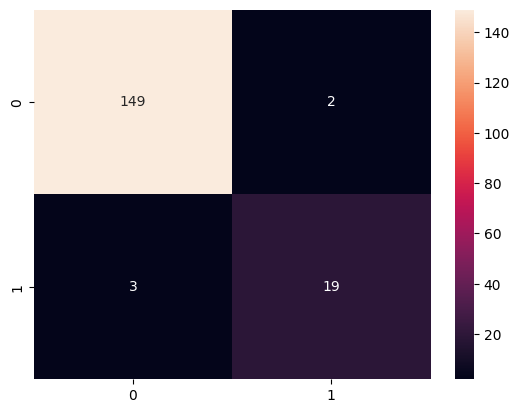

In [104]:
# Compute the confusion matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix_test, annot=True, fmt='.0f')

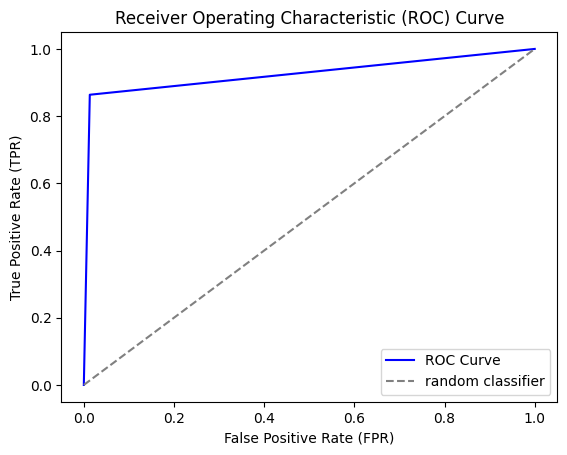

In [105]:
draw_roc(y_test, y_test_prob)

# Results Summary

## ROC Curves

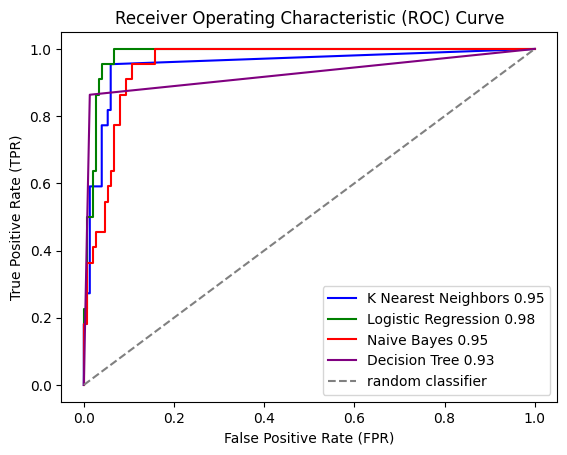

<Axes: xlabel='Metric'>

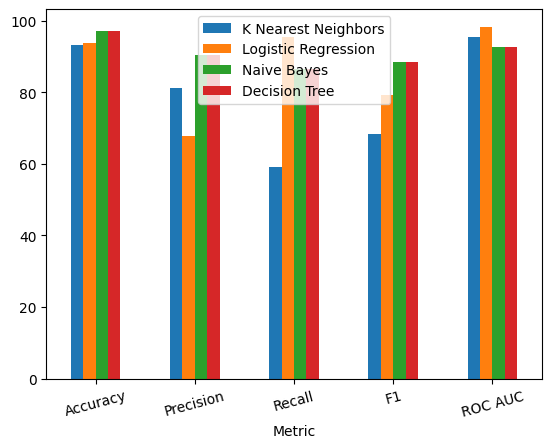

In [106]:
# Add Decision Tree ROC curve
plt.plot(curves[0][0], curves[0][1], color='blue', label=f'K Nearest Neighbors {curves[0][2]:.2f}')
plt.plot(curves[1][0], curves[1][1], color='green', label=f'Logistic Regression {curves[1][2]:.2f}')
plt.plot(curves[2][0], curves[2][1], color='red', label=f'Naive Bayes {curves[2][2]:.2f}')
plt.plot(curves[3][0], curves[3][1], color='purple', label=f'Decision Tree {curves[3][2]:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='random classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Update metrics comparison
metrics = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1", "ROC AUC"],
    "K Nearest Neighbors": knn_metrics["values"],
    "Logistic Regression": logistic_metrics["values"],
    "Naive Bayes": bayes_metrics["values"],
    "Decision Tree": decision_tree_metrics["values"],
})
metrics.plot(x="Metric", kind="bar", rot=15)

## Other Metrics

<Axes: xlabel='Metric'>

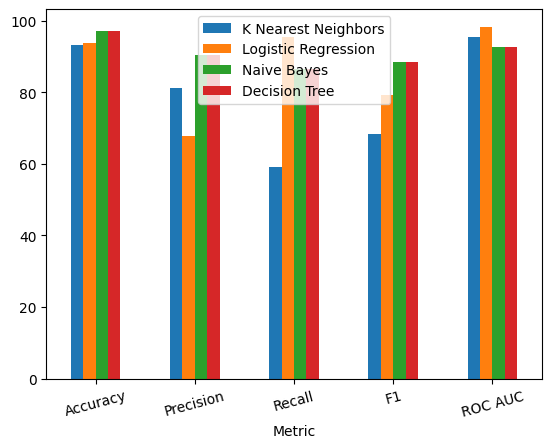

In [107]:
metrics = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1", "ROC AUC"],
    "K Nearest Neighbors": knn_metrics["values"],
    "Logistic Regression": logistic_metrics["values"],
    "Naive Bayes": bayes_metrics["values"],
    "Decision Tree": decision_tree_metrics["values"],
})
metrics.plot(x="Metric", kind="bar", rot=15)